# <center>1. Introduction </center>


### This example demonstrates the following main functionalities of portpy_photon:


1. Accessing the curated portpy data
    (DataExplorer class)

2. Creating a simple IMRT plan
    (Plan class, Optimization class)

3. Visualising the plan (e.g., dose distribution, fluence, DVH)
   (Visualization class)

4. Evaluating the plan (e.g., max/mean/DVH points, established clinical metrics)
    (Evaluation class)

5. Saving the plan and solution for future uses
    (Utils)

6. Advanced plan visualization through integration with a popular 3D-Slicer package
    (Visualization class)


### 1) Accessing the portpy data (DataExplorer class)
 Note: you first need to download the patient database from the link provided in the GitHub page.


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import numpy as np
import os

In [3]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# display the existing patients in console or browser.
data.display_list_of_patients()

,patient_id,disease_site,ptv_vol_cc,num_beams
0,Lung_Patient_2,Lung,737.229,72
1,Lung_Phantom_Patient_1,Lung,43.902,72
2,Lung_Phantom_Patient_3,Lung,49.425,72


In [4]:
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Phantom_Patient_1'
# display the data of the patient in console or browser.
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [5]:
structs_df.head()

,name,volume_cc
0,GTV,27.629362
1,LUNGS_NOT_GTV,2983.244630
2,PTV,43.901787
3,CORD,5.307685
4,HEART,841.405457


In [6]:
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params=opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done


### 2) Creating a simple IMRT plan using CVXPy (Plan class, Optimization class)
Note: you can call different opensource / commercial optimization engines from CVXPy.
  For commercial engines (e.g., Mosek, Gorubi, CPLEX), you first need to obtain an appropriate license.
  Most commercial optimization engines give free academic license.

Create my_plan object which would store all the data needed for optimization
  (e.g., influence matrix, structures and their voxels, beams and their beamlets).


In [7]:
# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct, structs, beams, inf_matrix, clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done



#### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation


$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x} \geq 0
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [8]:
sol = opt.solve(solver='MOSEK', verbose=True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 30 10:34:26 AM: Your problem has 1945 variables, 14 constraints, and 0 parameters.
(CVXPY) May 30 10:34:26 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 30 10:34:26 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 30 10:34:26 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 30 10:34:26 AM: Compiling problem (target solver=MOSEK).
(CVXPY) May 30 10:34:26 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) May 30 10:34:30 AM: 
(CVXPY) May 30 10:34:30 AM: 
(CVXPY) May 30 10:34:30 AM: Interior-point solution summary
(CVXPY) May 30 10:34:30 AM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) May 30 10:34:30 AM:   Solution status : OPTIMAL
(CVXPY) May 30 10:34:30 AM:   Primal.  obj: 4.1909288064e+01    nrm: 1e+02    Viol.  con: 3e-06    var: 6e-07    cones: 0e+00  
(CVXPY) May 30 10:34:30 AM:   Dual.    obj: 4.1909288064e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 3e-09    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) May 30 10:34:30 AM: Problem status: optimal
(CVXPY) May 30 10:34:30 AM: Optimal value: 4.191e+01
(CVXPY) May 30 10:34:30 AM: Compilation took 1.655e+00 seconds
(CVXPY) May 30 10:34:30 AM: Solver (including time spent in interface) took 2.949e+00 sec

### 3) Visualizing the plan (Visualization class)

<Axes: xlabel='x-axis (beamlets column)', ylabel='y-axis (beamlets row)'>

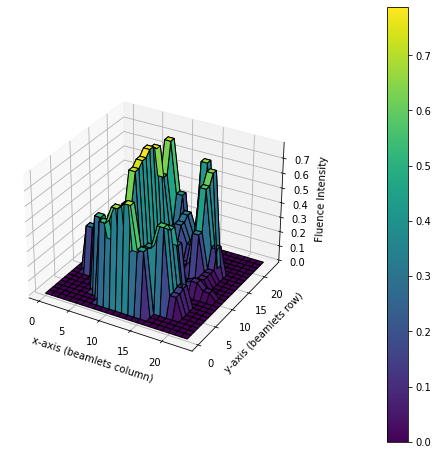

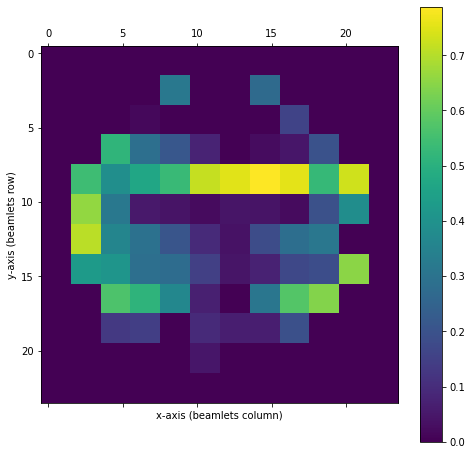

In [9]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

pp.Visualization.plot_fluence_2d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])


<Axes: title={'center': 'Lung_Phantom_Patient_1'}, xlabel='Dose (Gy)', ylabel='Volume Fraction (%)'>

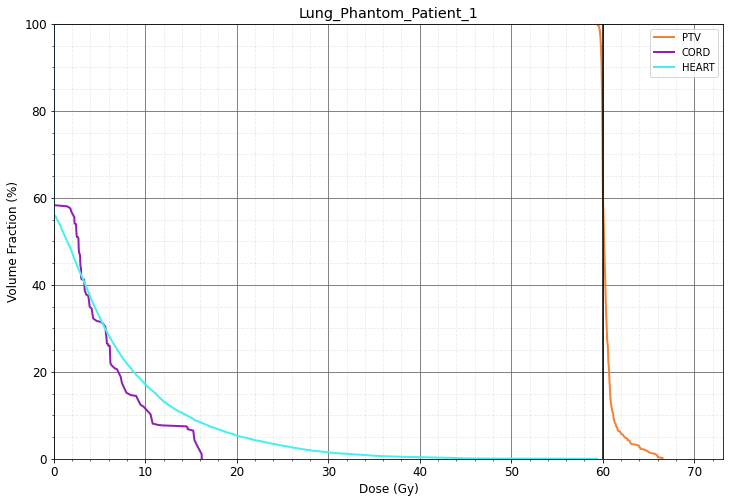

In [10]:
# plot dvh for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

# plot dvh for the above structures
pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, title=data.patient_id)


<Axes: title={'center': 'Axial View - Slice #: 60'}>

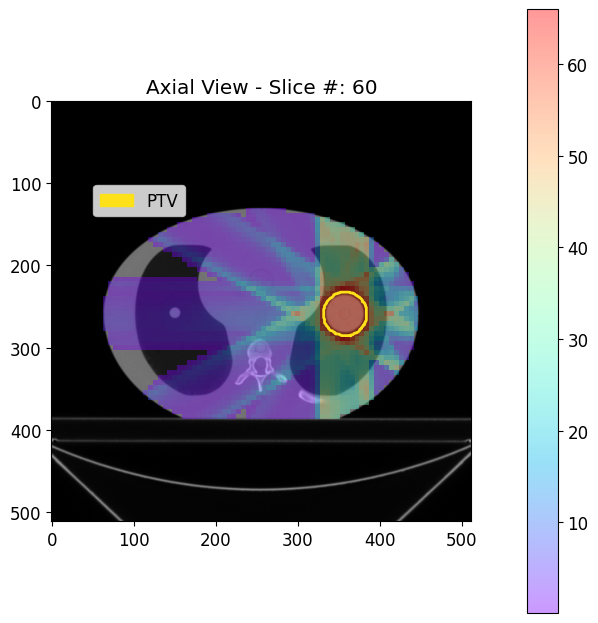

In [11]:
# plot 2d axial slice for the given solution and display the structures contours on the slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV'])

### 4) Evaluating the plan (Evaluation class)

In [12]:
# visualize plan metrics based upon clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=sol)

,name,parameters,constraints,Plan Value
0,max_dose,{'structure_name': 'GTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",66.528396
1,max_dose,{'structure_name': 'PTV'},"{'limit_dose_gy': 69, 'goal_dose_gy': 66}",66.528396
2,max_dose,{'structure_name': 'HEART'},{'limit_dose_gy': 66},59.352347
3,mean_dose,{'structure_name': 'HEART'},"{'limit_dose_gy': 27, 'goal_dose_gy': 20}",4.858251
4,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'limit_volume_perc': 50},1.474882
5,dose_volume_V,"{'structure_name': 'HEART', 'dose_gy': 30}",{'goal_volume_perc': 48},1.474882
6,max_dose,{'structure_name': 'LUNG_L'},{'limit_dose_gy': 66},66.000000
7,max_dose,{'structure_name': 'LUNG_R'},{'limit_dose_gy': 66},25.938140
8,max_dose,{'structure_name': 'CORD'},"{'limit_dose_gy': 50, 'goal_dose_gy': 48}",16.169946
9,max_dose,{'structure_name': 'SKIN'},{'limit_dose_gy': 60},50.987951


### 5) Saving and loading the plan for future use (utils)

In [13]:
# Comment/Uncomment these lines to save and load the pickle file for plans and optimal solution from the directory
pp.save_plan(my_plan, plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
pp.save_optimal_sol(sol, sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# my_plan = pp.load_plan(plan_name='my_plan_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))
# sol = pp.load_optimal_sol(sol_name='sol_phantom.pkl', path=os.path.join(r'C:\temp', data.patient_id))

### 6) Advanced visualization with 3D-Slicer (Visualization class)

In [14]:
# Note: This requires downloading and installing 3d slicer
#   3D slicer integration is seamless with Jupiter Notebook (see ex_7_Slicer).
# Without Jupiter Notebook, we first need to save our data (ct, 3D dose, structures)
#   as images in nrrd format on disk and then lunch Slicer by providing data as input argument
pp.save_nrrd(my_plan, sol=sol, data_dir=os.path.join(r'C:\temp', data.patient_id))
pp.Visualization.view_in_slicer(my_plan, slicer_path=r'C:\ProgramData\NA-MIC\Slicer 5.2.1\Slicer.exe',
                                data_dir=os.path.join(r'C:\temp', data.patient_id))
print('Done!')


Done
Done!
